<h1 style="text-align: center; font-weight: bold;"><u>Import et chargement des données</u></h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from mesFonctions import tokenize_english_descriptions, afficher_tokens, get_word_frequencies, plot_word_frequencies, get_word_frequencies_filtered, get_word_frequencies_lemmatized, get_lemmatized_frequencies_by_description, plot_bow_heatmap, apply_tfidf, plot_top_tfidf_words, reduce_tsne, cluster_kmeans, plot_tsne, extract_unique_categories, extract_category, vectorize_text, plot_2D_clusters, use_vectorize, bert_vectorize, generate_wordclouds_by_category_with_extraction, reduce_tsne_bert_use, get_image_size
import os
from nltk.data import path as nltk_data_path
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim.models import Word2Vec
from wordcloud import WordCloud
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import time
import csv

logs = []

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pac

In [2]:
# Répertoire local pour les ressources NLTK
nltk_data_dir = './nltk_data/tokenizers'
nltk.data.path.append(nltk_data_dir)
# nltk.download('punkt')
# nltk.download('all')  # Plus long, mais pratique pour éviter les surprises

# Téléchargement explicite du bon corpus
nltk.download('punkt', download_dir=nltk_data_dir)
# Ajout manuellement le chemin
nltk_data_path.append(os.path.abspath('./nltk_data'))
nltk.download('wordnet')
nltk.download('omw-1.4')  # Dictionnaire multilingue

[nltk_data] Downloading package punkt to ./nltk_data/tokenizers...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<h1 style="text-align: center; font-weight: bold;"><u>Étape 1 Étude de faisabilité d'un moteur de classification automatique</u></h1>

In [3]:
df = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [4]:
df.duplicated(subset=['product_name', 'description']).sum()

0

In [5]:
df['product_name'].str.len().describe()
df[df['product_name'].str.strip().str.len() < 5]

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications]
Index: []

In [6]:
df['description'].str.len().describe()
df[df['description'].str.strip().str.len() < 10]

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications]
Index: []

In [7]:
df_categories = extract_unique_categories(df)
print(df_categories["extracted_category"])

0               Home Furnishing
1                     Baby Care
2                       Watches
3    Home Decor & Festive Needs
4              Kitchen & Dining
5      Beauty and Personal Care
6                     Computers
Name: extracted_category, dtype: object


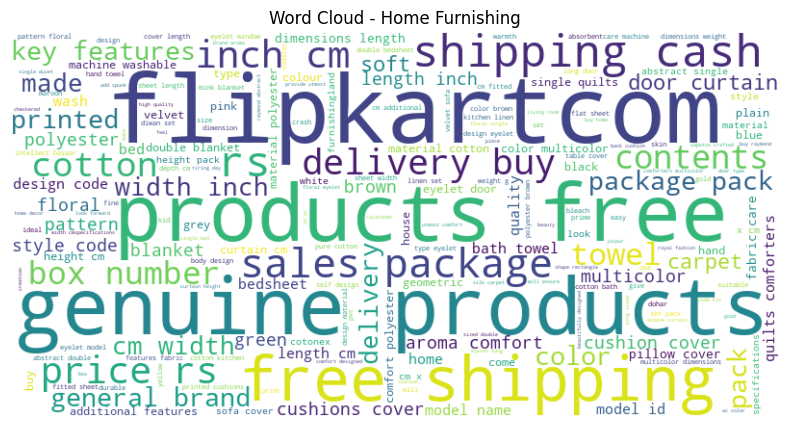

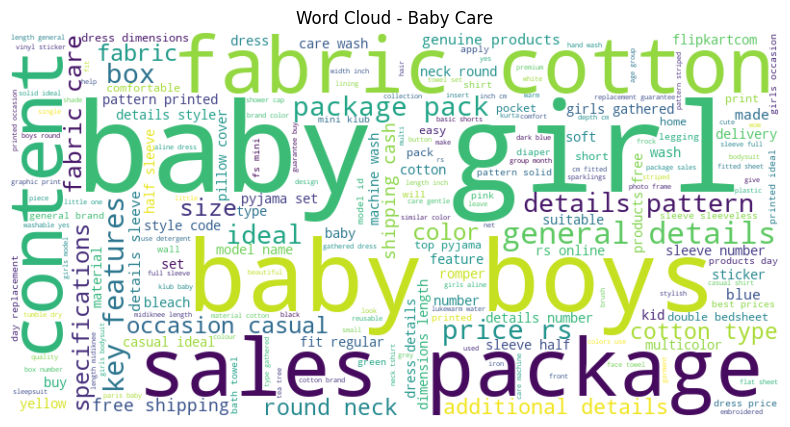

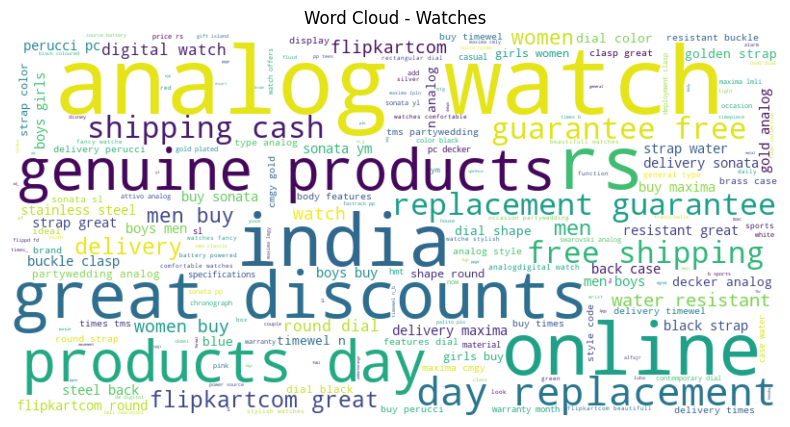

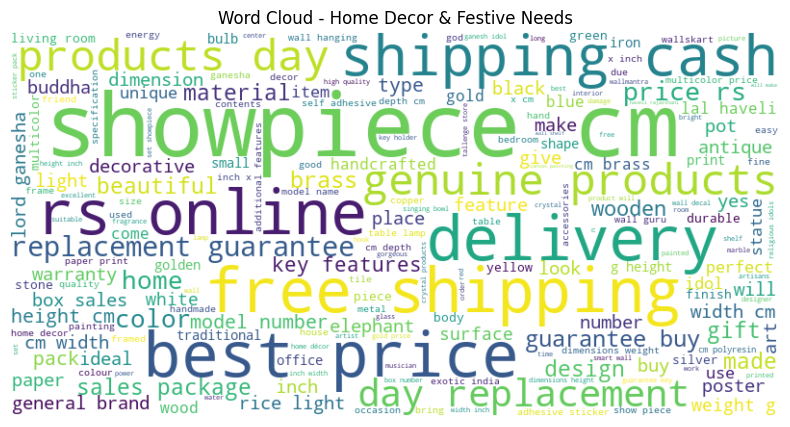

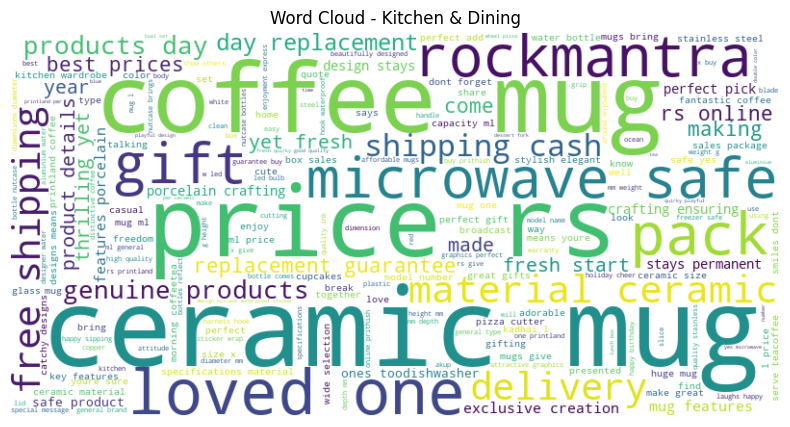

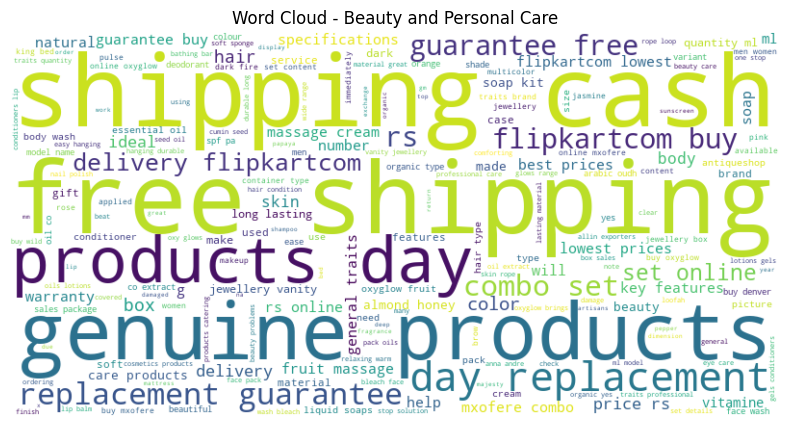

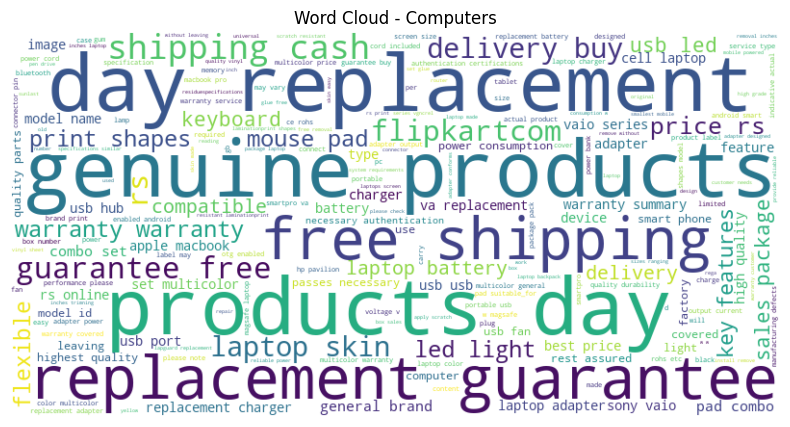

In [8]:
generate_wordclouds_by_category_with_extraction(df, text_column='description', category_column='product_category_tree')

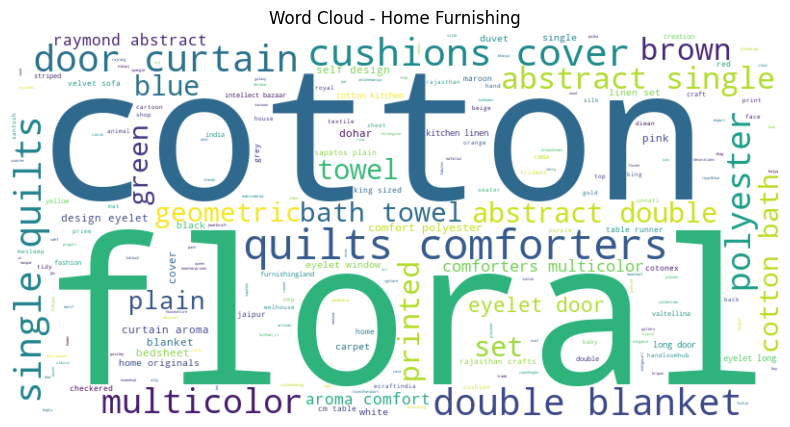

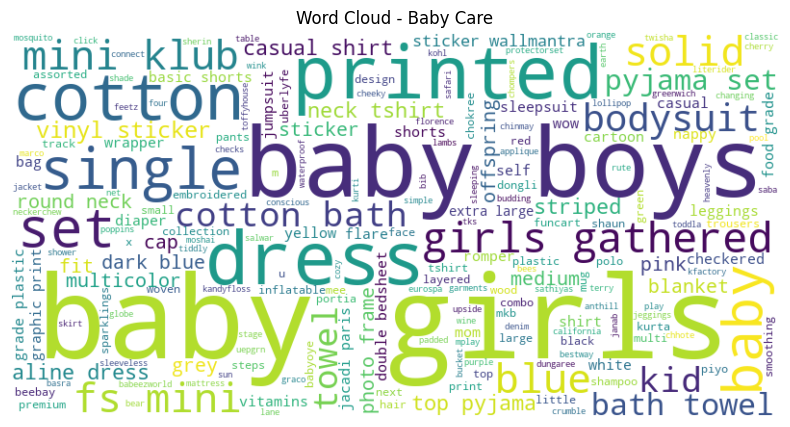

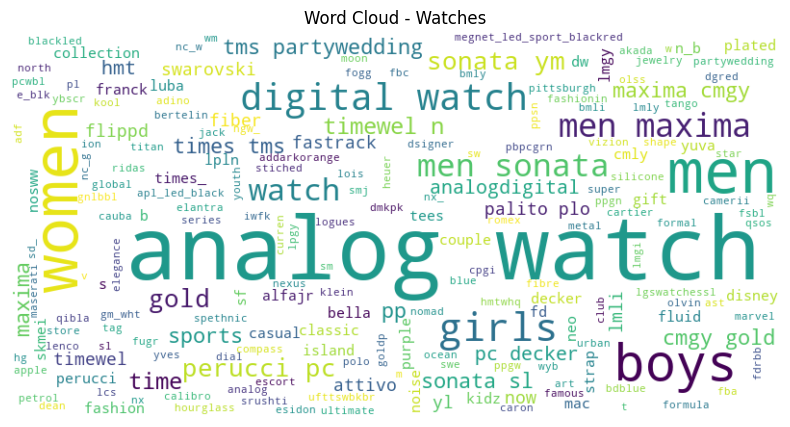

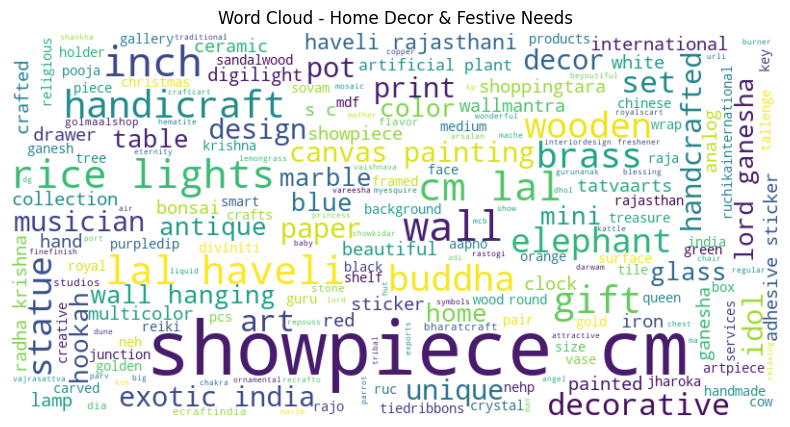

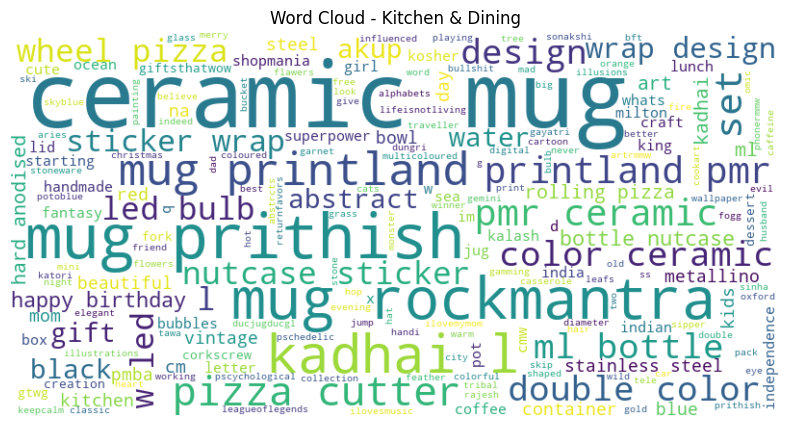

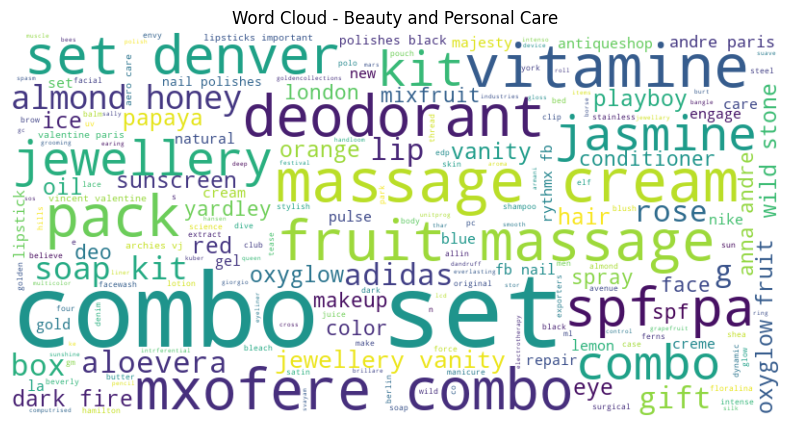

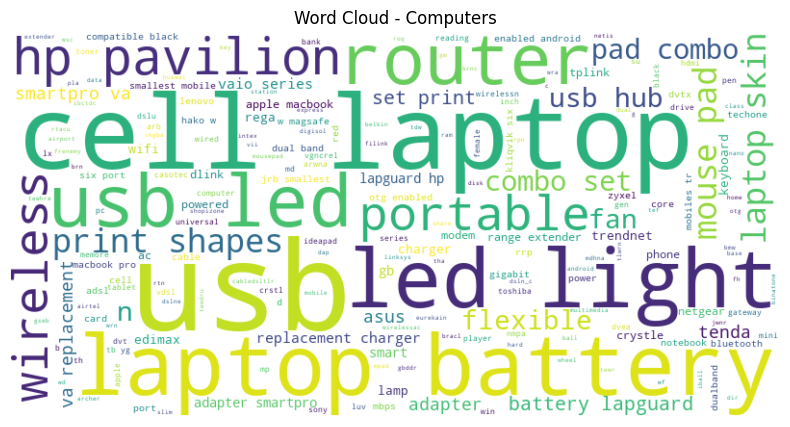

In [9]:
generate_wordclouds_by_category_with_extraction(df, text_column='product_name', category_column='product_category_tree')

In [10]:
df["extracted_category"] = df["product_category_tree"].apply(extract_category)
print(df["extracted_category"])

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: extracted_category, Length: 1050, dtype: object


In [11]:
# Nombre total de lignes (produits)
nb_produits = len(df['uniq_id'])

# Nombre de descriptions non nulles
nb_descriptions = df['description'].notnull().sum()

print(f"Nombre total de produits : {nb_produits}")
print(f"Nombre de descriptions non nulles : {nb_descriptions}")

Nombre total de produits : 1050
Nombre de descriptions non nulles : 1050


In [12]:
# Nombre de catégories distinctes
nb_categories = df['product_category_tree'].nunique()

# Nombre de produits par catégorie
produits_par_categorie = df['product_category_tree'].value_counts()

print(f"Nombre de catégories distinctes : {nb_categories}")
print("Nombre de produits par catégorie :")
print(produits_par_categorie)

Nombre de catégories distinctes : 642
Nombre de produits par catégorie :
product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wr

<h1 style="text-align: center; font-weight: bold;"><u>1.1 Analyse textuelle</u></h1>

<h2 style="text-align: left; font-weight: bold;"><u>Tokenization pour la colonne description</u></h2>

In [13]:
# Application de la fonction
df = tokenize_english_descriptions(df, desc_col='description')
df['tokens_description'] = df['tokens']  # si tu veux vraiment renommer pour plus de clarté

# Exemple : afficher la ligne 5
afficher_tokens(df, 5)

Langue : en

Description originale :
 Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!

Tokens :
 ['maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys', 'buy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys', 'r8851116001', 'online', 'at', 'rs', '24400', 'in', 'india', 'only', 'at', 'flipkart', 'com', 'great', 'discounts', 'only', 'genuine', 'products', '30', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'on', 'delivery']


In [14]:
# Étape 2 : Obtenir les fréquences des mots
frequencies = get_word_frequencies(df, tokens_col='tokens_description')

# Afficher les 10 mots les plus fréquents
print(frequencies.head(10))

   word  frequency
0    of       1751
1   for       1436
2   the       1369
3   and       1332
4    to       1058
5    in       1047
6    rs        911
7  only        890
8  with        843
9    on        835


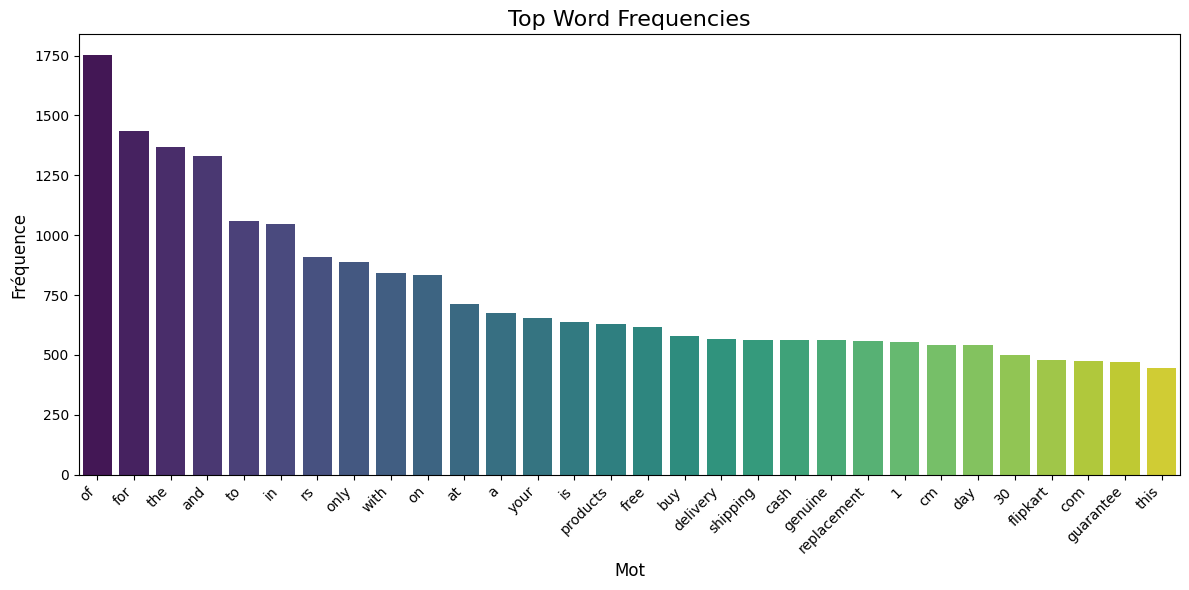

In [15]:
plot_word_frequencies(frequencies, top_n=30)

<h2 style="text-align: left; font-weight: bold;"><u>Tokenization pour la colonne titre</u></h2>

In [16]:
# Application de la fonction
df = tokenize_english_descriptions(df, desc_col='product_name')
df['tokens_titre'] = df['tokens']  # si tu veux vraiment renommer pour plus de clarté

# Exemple : afficher la ligne 5
afficher_tokens(df, 5, col='product_name')

Langue : en

Titre original :
 Maserati Time R8851116001 Analog Watch  - For Boys

Tokens :
 ['maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys']


In [17]:
# Étape 2 : Obtenir les fréquences des mots
frequencies = get_word_frequencies(df, tokens_col='tokens_titre')

# Afficher les 10 mots les plus fréquents
print(frequencies.head(10))

        word  frequency
0        for        151
1      watch        134
2     analog        118
3        set        107
4         cm         97
5          s         95
6  showpiece         94
7       baby         89
8      combo         74
9    ceramic         73


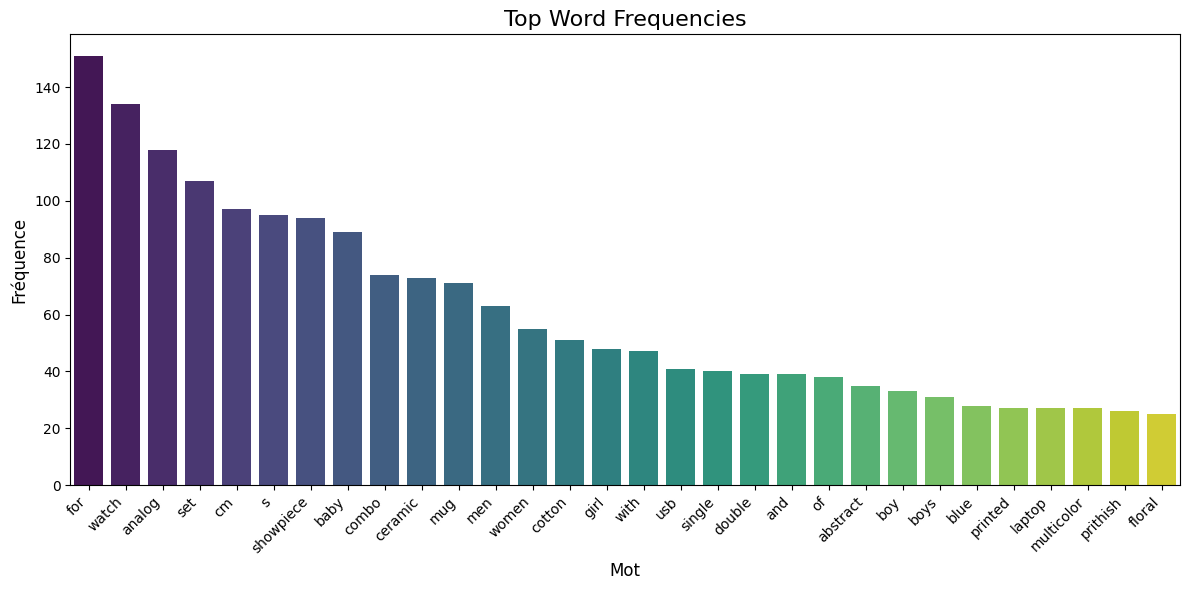

In [18]:
plot_word_frequencies(frequencies, top_n=30)

In [19]:
print(df.columns)

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications',
       'extracted_category', 'lang', 'tokens', 'tokens_description',
       'tokens_titre'],
      dtype='object')


<h2 style="text-align: left; font-weight: bold;"><u>Stopwords pour la colonne description</u></h2>

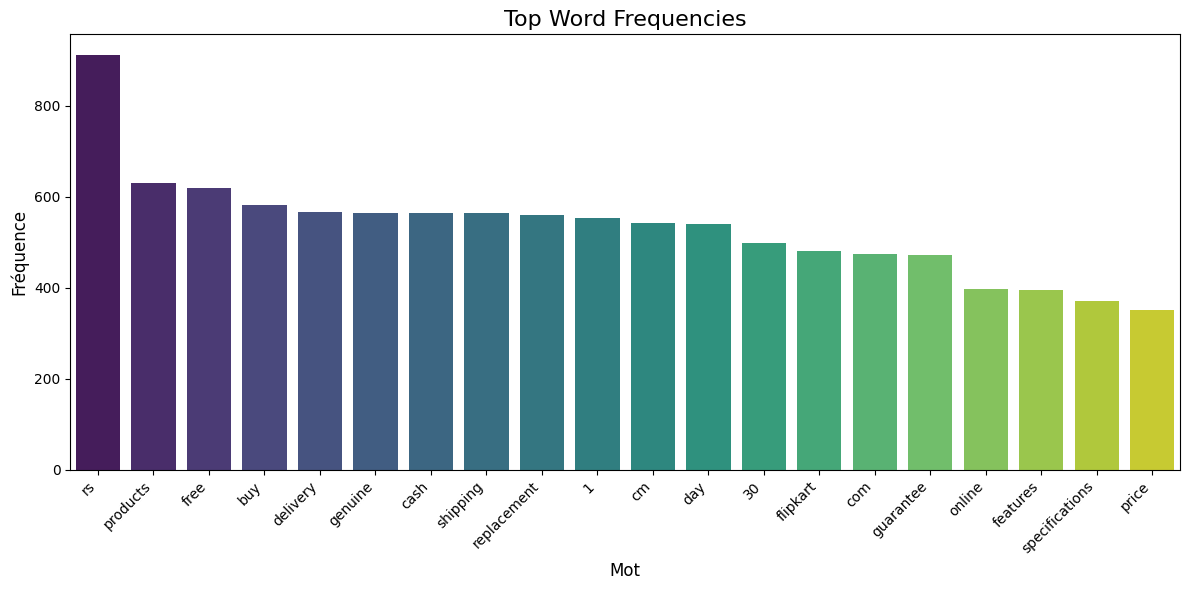

In [20]:
freq_df_filtered = get_word_frequencies_filtered(df, token_col='tokens_description')
plot_word_frequencies(freq_df_filtered, top_n=20)

<h2 style="text-align: left; font-weight: bold;"><u>Stopwords pour la colonne titre</u></h2>

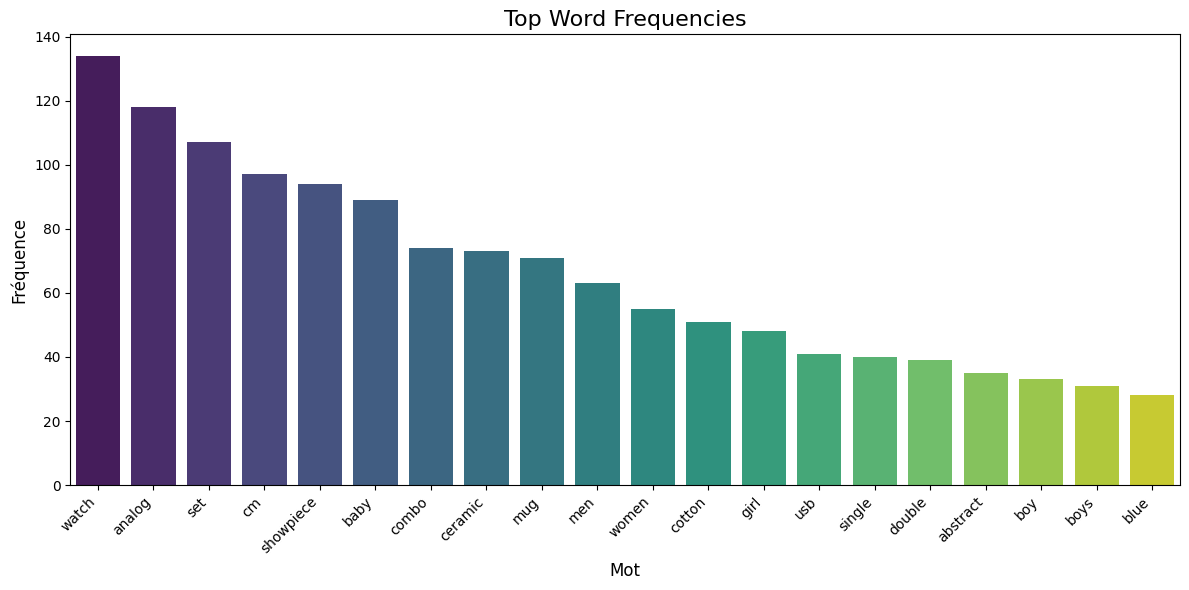

In [21]:
freq_df_filtered = get_word_frequencies_filtered(df, token_col='tokens_titre')
plot_word_frequencies(freq_df_filtered, top_n=20)

<h2 style="text-align: left; font-weight: bold;"><u>Lemmatisation ou racinisation (stemming) pour la colonne description</u></h2>

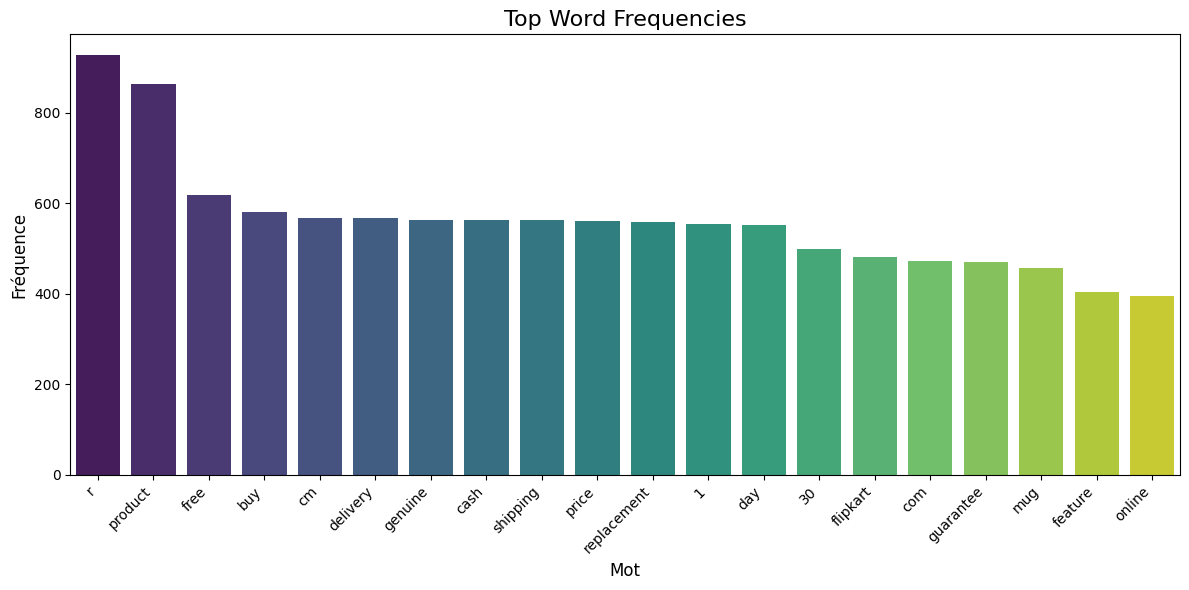

In [22]:
freq_df_lemmatized = get_word_frequencies_lemmatized(df, token_col='tokens_description')
plot_word_frequencies(freq_df_lemmatized, top_n=20)

<h2 style="text-align: left; font-weight: bold;"><u>Lemmatisation ou racinisation (stemming) pour la colonne titre</u></h2>

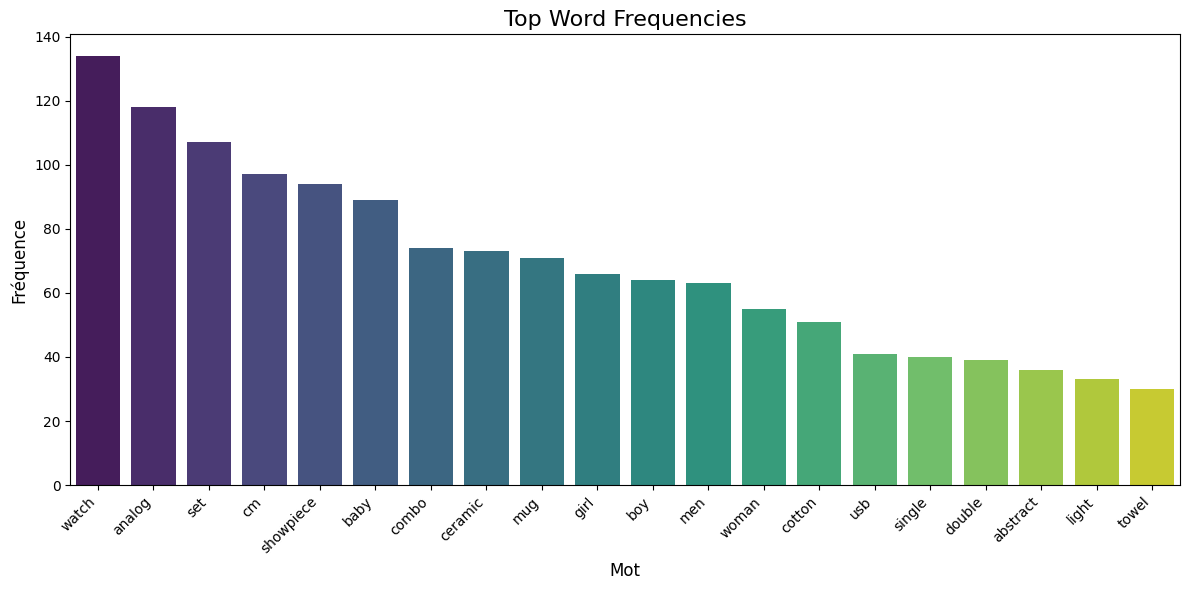

In [23]:
freq_df_lemmatized = get_word_frequencies_lemmatized(df, token_col='tokens_titre')
plot_word_frequencies(freq_df_lemmatized, top_n=20)

<h2 style="text-align: left; font-weight: bold;"><u>Bag of Words pour la colonne description</u></h2>

In [24]:
df_bow = get_lemmatized_frequencies_by_description(df, desc_col='description')
print(df_bow.head())

   key  feature  elegance  polyester  multicolor  abstract  eyelet  door  \
0    1        2         4          6           4         4       6     5   
1    0        1         0          0           0         0       0     0   
2    1        2         0          0           0         0       0     0   
3    1        1         0          0           2         0       0     0   
4    1        1         0          0           0         0       0     0   

   curtain  floral  ...  member  deserves  sweeping  personalise  receive  \
0       11       1  ...       0         0         0            0        0   
1        0       0  ...       0         0         0            0        0   
2        0       0  ...       0         0         0            0        0   
3        0       0  ...       0         0         0            0        0   
4        0       3  ...       0         0         0            0        0   

   final  practice  uberlyfe  polyvinyl  film  
0      0         0         0    

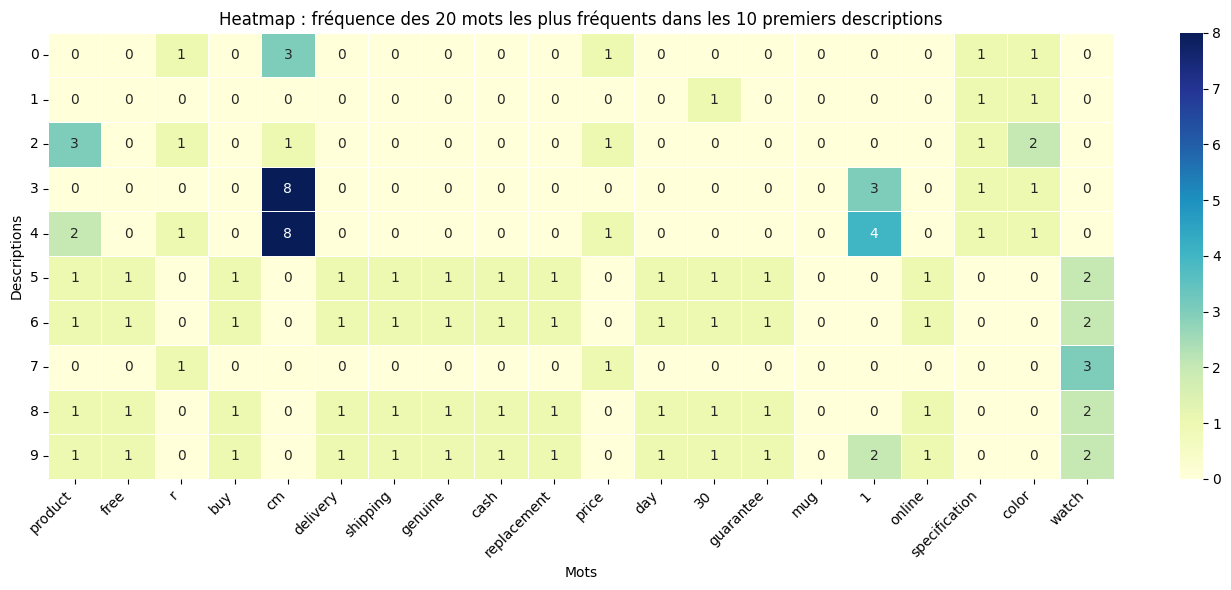

In [25]:
plot_bow_heatmap(df_bow, top_n_words=20, nb_resultats=10, type_contenu='descriptions')

<h2 style="text-align: left; font-weight: bold;"><u>Bag of Words pour la colonne titre</u></h2>

In [26]:
df_bow_titre = get_lemmatized_frequencies_by_description(df, desc_col='product_name')
print(df_bow_titre.head())

   elegance  polyester  multicolor  abstract  eyelet  door  curtain  sathiyas  \
0         1          1           1         1       1     1        1         0   
1         0          0           0         0       0     0        0         1   
2         0          0           0         0       0     0        0         0   
3         0          0           0         0       0     0        0         0   
4         0          0           0         0       0     0        0         0   

   cotton  bath  ...  extra  walldesign  999store  oren  empower  uberlyfe  \
0       0     0  ...      0           0         0     0        0         0   
1       1     1  ...      0           0         0     0        0         0   
2       1     0  ...      0           0         0     0        0         0   
3       1     0  ...      0           0         0     0        0         0   
4       1     0  ...      0           0         0     0        0         0   

   pigmented  polyvinyl  film  imported  
0 

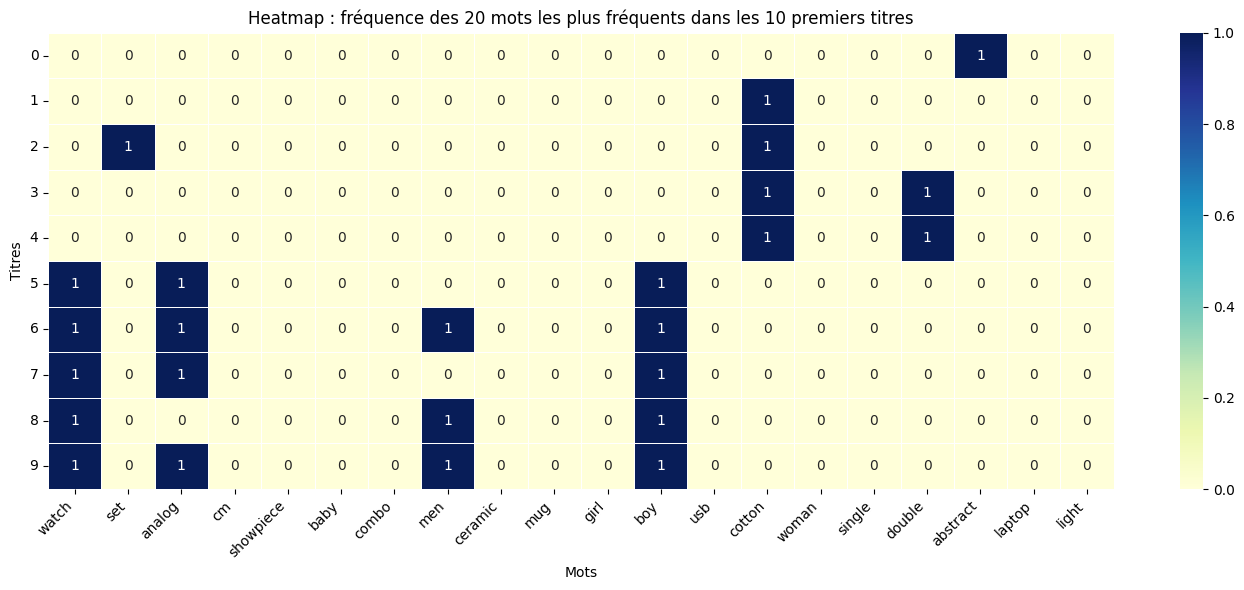

In [27]:
plot_bow_heatmap(df_bow_titre, top_n_words=20, nb_resultats=10, type_contenu='titres')

<h2 style="text-align: left; font-weight: bold;"><u>T-SNE pour bag of words de la colonne description</u></h2>

In [28]:
vectorizer_bow = CountVectorizer(stop_words='english')
X_bow = vectorizer_bow.fit_transform(df['description'].astype(str))

In [29]:
X_bow_2d = reduce_tsne(X_bow)

In [30]:
start = time.time()
clusters_bow = cluster_kmeans(X_bow_2d)
elapsed = time.time() - start

In [31]:
ari_bow = adjusted_rand_score(df["extracted_category"], clusters_bow)
now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative = "kmeans_bag_of_words_description"

logs.append({
    "nom_tentative": nom_tentative,
    "date_heure": now,
    "ARI": ari_bow,
    "temps_sec": elapsed
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)
    
print(f"ARI BoW : {ari_bow:.4f}")

ARI BoW : 0.3590


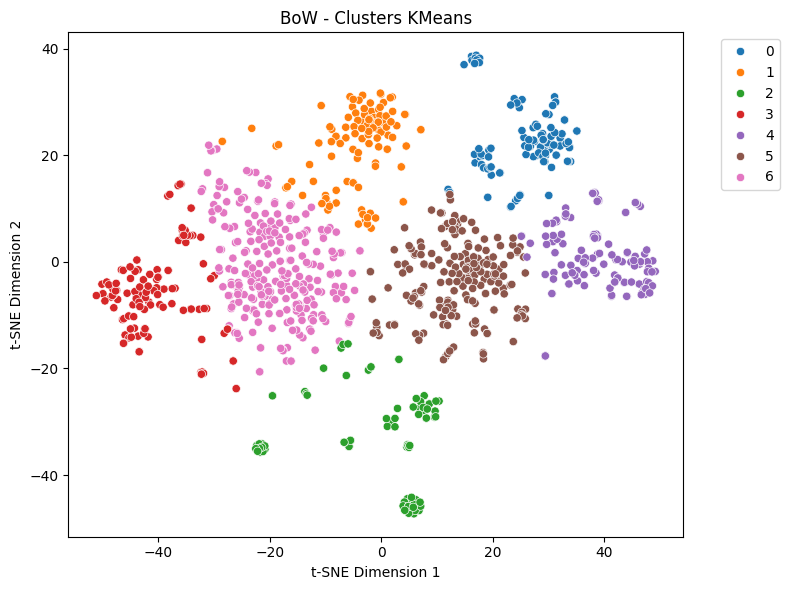

In [32]:
plot_tsne(X_bow_2d, clusters_bow, "BoW - Clusters KMeans")

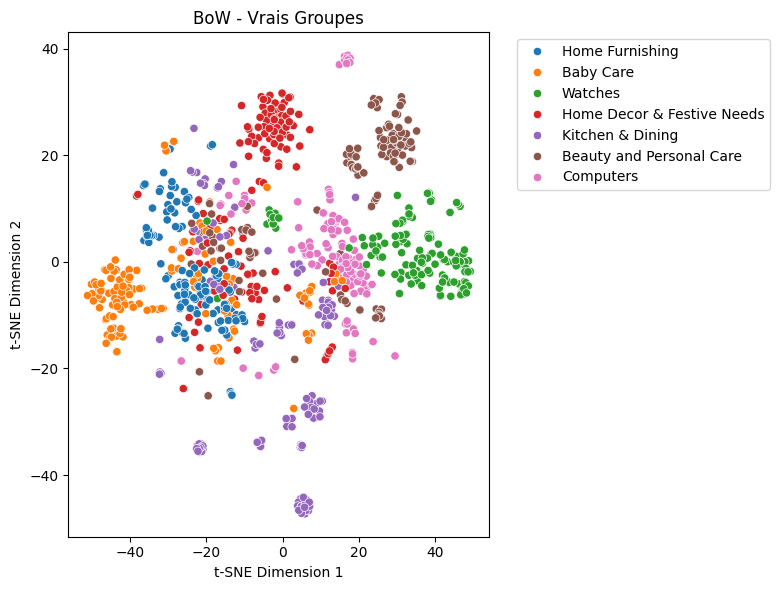

In [33]:
plot_tsne(X_bow_2d, df["extracted_category"], "BoW - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>T-SNE pour bag of words de la colonne titre</u></h2>

In [34]:
vectorizer_bow = CountVectorizer(stop_words='english')
X_bow_titre = vectorizer_bow.fit_transform(df['product_name'].astype(str))

In [35]:
X_bow_2d_titre = reduce_tsne(X_bow_titre)

In [36]:
start2 = time.time()
clusters_bow = cluster_kmeans(X_bow_2d_titre)
elapsed2 = time.time() - start2

In [37]:
ari_bow = adjusted_rand_score(df["extracted_category"], clusters_bow)
now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative = "kmeans_bag_of_words_titre"

logs.append({
    "nom_tentative": nom_tentative,
    "date_heure": now,
    "ARI": ari_bow,
    "temps_sec": elapsed2
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)
    
print(f"ARI BoW : {ari_bow:.4f}")

ARI BoW : 0.3930


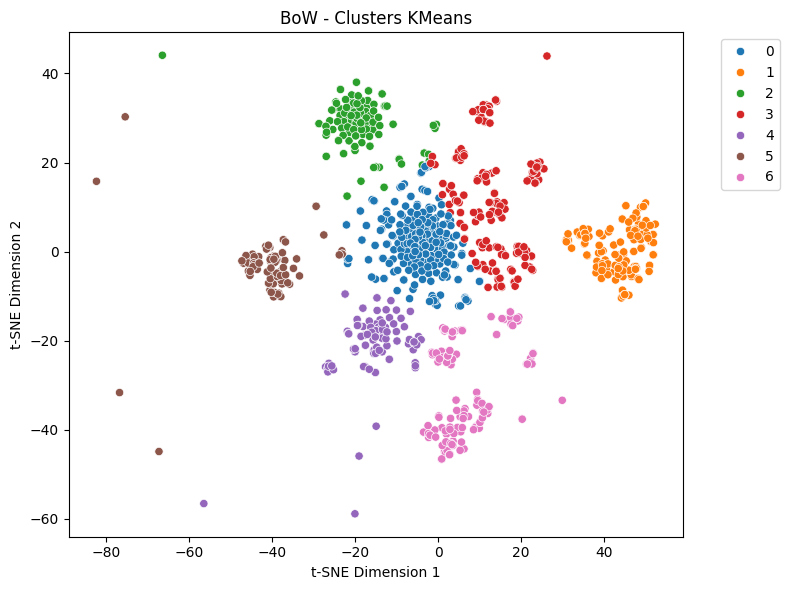

In [38]:
plot_tsne(X_bow_2d_titre, clusters_bow, "BoW - Clusters KMeans")

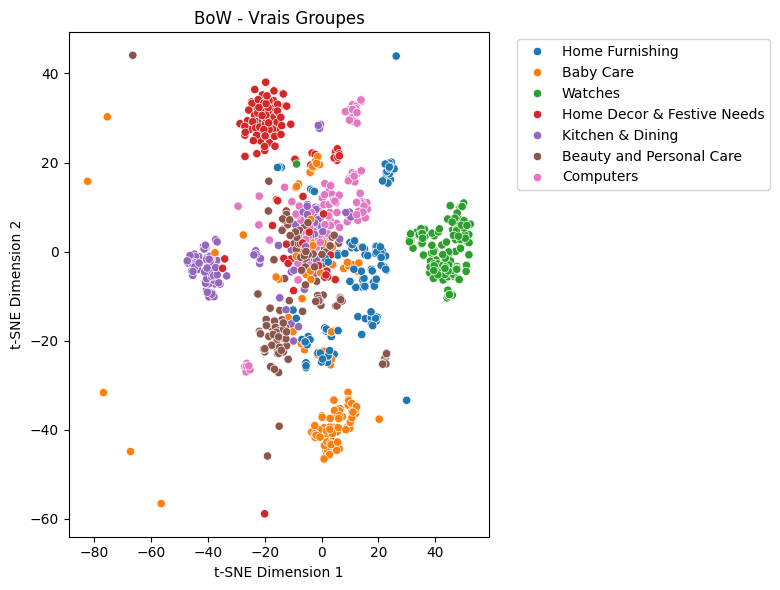

In [39]:
plot_tsne(X_bow_2d_titre, df["extracted_category"], "BoW - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>TF-IDF pour la colonne description</u></h2>

In [40]:
df_tfidf = apply_tfidf(df_bow)
print(df_tfidf.head())

   elegance  polyester  multicolor  abstract    eyelet      door   curtain  \
0  0.240785   0.275781    0.139393  0.166256  0.298105  0.250989  0.536027   
1  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000   0.000000    0.078833  0.000000  0.000000  0.000000  0.000000   
4  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   

     floral       213        cm  ...  sweeping  personalise  receive  final  \
0  0.042743  0.190697  0.080336  ...       0.0          0.0      0.0    0.0   
1  0.000000  0.000000  0.000000  ...       0.0          0.0      0.0    0.0   
2  0.000000  0.000000  0.024430  ...       0.0          0.0      0.0    0.0   
3  0.000000  0.000000  0.242313  ...       0.0          0.0      0.0    0.0   
4  0.117243  0.000000  0.195875  ...       0.0          0.0      0.0    0.0   

   practice  uberlyfe  polyvinyl  film  key  feature  
0

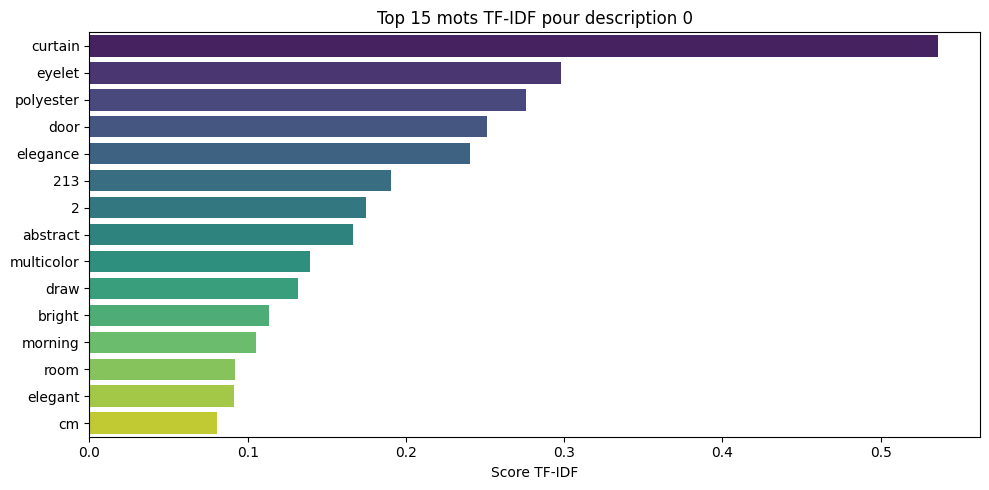

In [41]:
# Exclure les colonnes d'identifiants
id_columns = ['key', 'feature']
tfidf_matrix = df_tfidf.drop(columns=id_columns).values  # numpy array
feature_names = df_tfidf.drop(columns=id_columns).columns.tolist()
plot_top_tfidf_words(tfidf_matrix, feature_names, doc_index=0, top_n=15)

<h2 style="text-align: left; font-weight: bold;"><u>TF-IDF pour la colonne titre</u></h2>

In [42]:
df_tfidf_titre = apply_tfidf(df_bow_titre)
print(df_tfidf_titre.head())

   elegance  polyester  multicolor  abstract    eyelet      door   curtain  \
0  0.504358   0.357848    0.335041  0.315748  0.364856  0.376807  0.361269   
1  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000   0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   

   sathiyas    cotton      bath  ...  walldesign  999store  oren  empower  \
0   0.00000  0.000000  0.000000  ...         0.0       0.0   0.0      0.0   
1   0.68089  0.368561  0.469876  ...         0.0       0.0   0.0      0.0   
2   0.00000  0.296027  0.000000  ...         0.0       0.0   0.0      0.0   
3   0.00000  0.237117  0.000000  ...         0.0       0.0   0.0      0.0   
4   0.00000  0.267244  0.000000  ...         0.0       0.0   0.0      0.0   

   uberlyfe  pigmented  polyvinyl  film  imported  key  
0       0.0

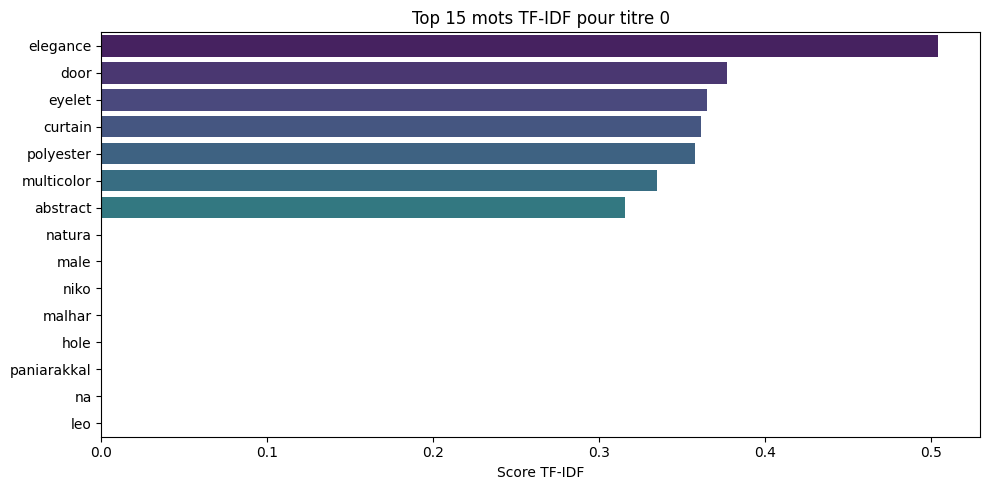

In [43]:
# Exclure les colonnes d'identifiants
# id_columns = ['key', 'feature']
id_columns = [col for col in ['key', 'feature'] if col in df_tfidf_titre.columns]

tfidf_matrix = df_tfidf_titre.drop(columns=id_columns).values  # numpy array
feature_names = df_tfidf_titre.drop(columns=id_columns).columns.tolist()
plot_top_tfidf_words(tfidf_matrix, feature_names, doc_index=0, top_n=15, source="titre")

<h2 style="text-align: left; font-weight: bold;"><u>T-SNE pour TF-IDF description</u></h2>

In [44]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(df['description'].astype(str))

In [45]:
X_tfidf_2d = reduce_tsne(X_tfidf)

In [46]:
start3 = time.time()
clusters_tfidf = cluster_kmeans(X_tfidf_2d)
elapsed3 = time.time() - start3

In [47]:
ari_tfidf = adjusted_rand_score(df["extracted_category"], clusters_tfidf)

now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative = "kmeans_TF_IDF_description"

logs.append({
    "nom_tentative": nom_tentative,
    "date_heure": now,
    "ARI": ari_tfidf,
    "temps_sec": elapsed3
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)
    
print(f"ARI TF-IDF : {ari_tfidf:.4f}")

ARI TF-IDF : 0.5210


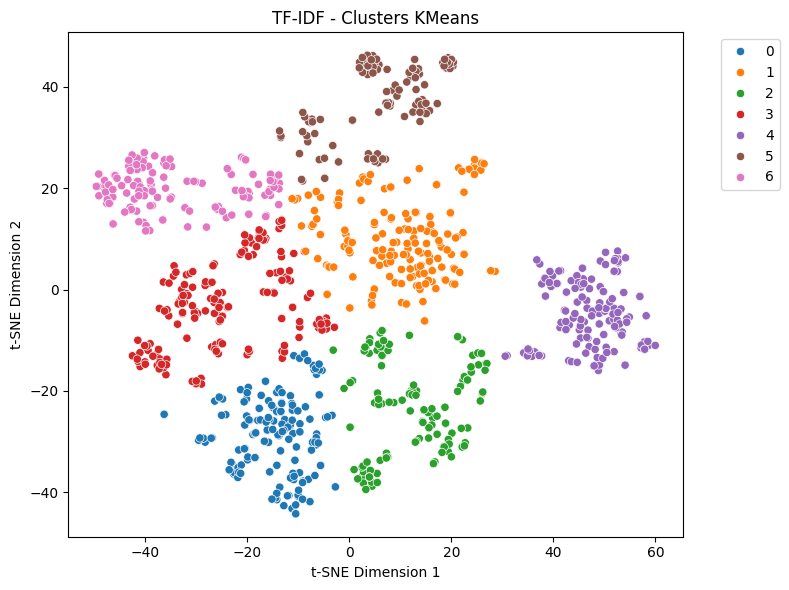

In [48]:
plot_tsne(X_tfidf_2d, clusters_tfidf, "TF-IDF - Clusters KMeans")

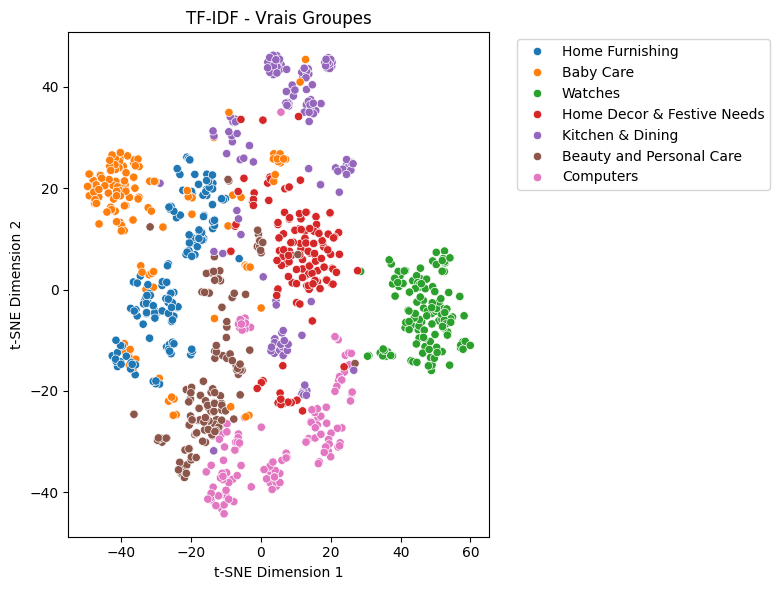

In [49]:
plot_tsne(X_tfidf_2d, df["extracted_category"], "TF-IDF - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>T-SNE pour TF-IDF titre</u></h2>

In [50]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_tfidf_titre = vectorizer_tfidf.fit_transform(df['product_name'].astype(str))

In [51]:
X_tfidf_2d_titre = reduce_tsne(X_tfidf_titre)

In [52]:
clusters_tfidf_titre = cluster_kmeans(X_tfidf_2d_titre)

In [53]:
ari_tfidf = adjusted_rand_score(df["extracted_category"], clusters_tfidf_titre)
print(f"ARI TF-IDF : {ari_tfidf:.4f}")

ARI TF-IDF : 0.4465


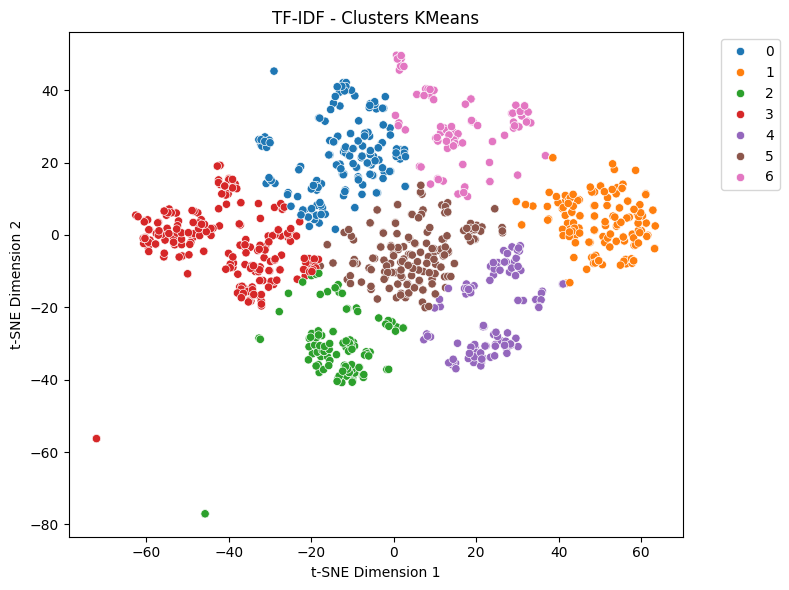

In [54]:
plot_tsne(X_tfidf_2d_titre, clusters_tfidf_titre, "TF-IDF - Clusters KMeans")

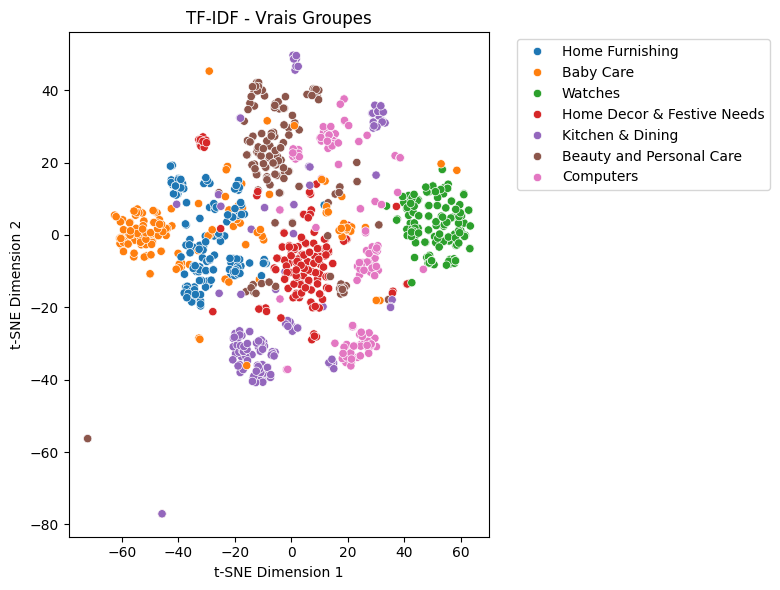

In [55]:
plot_tsne(X_tfidf_2d_titre, df["extracted_category"], "TF-IDF - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>Word2Vec pour la colonne description</u></h2>

In [56]:
afficher_tokens = df["description"].dropna().apply(word_tokenize).tolist()

In [57]:
model = Word2Vec(
    sentences=afficher_tokens,  # le corpus
    vector_size=100,             # dimension des vecteurs
    window=5,                    # taille du contexte
    min_count=2,                 # ignore les mots rares
    workers=4,                   # CPU cores
    sg=0                         # CBOW (mettre 1 pour skip-gram)
)


In [58]:
# Mots les plus similaires
print(model.wv.most_similar("buy", topn=5))

[('your', 0.9893472790718079), ('you', 0.984233021736145), ('to', 0.983735978603363), ('can', 0.9807437658309937), ('it', 0.9799277782440186)]


In [59]:
print(model.wv.most_similar("product", topn=5))

[('tone', 0.9796201586723328), ('settings', 0.9765363931655884), ('slightly', 0.9750872850418091), ('available', 0.9737552404403687), ('the', 0.9732435345649719)]


In [60]:
print(model.wv.most_similar("free", topn=5))

[('watch', 0.9975229501724243), ('battery', 0.9971911311149597), ('oil', 0.9971315264701843), ('replacement', 0.9967789649963379), ('carpet', 0.9964988231658936)]


In [61]:
# Analogie vectorielle
print(model.wv.most_similar(positive=["product", "delivery"], negative=["buy"]))


[('&', 0.8818607330322266), ('cash', 0.8712673783302307), ('Beautifull', 0.8520890474319458), ('shipping', 0.8506221175193787), ('customers', 0.8452547788619995), ('detail', 0.8412321209907532), ('Gods', 0.8386515378952026), ('Cow', 0.8355002999305725), ('smiles', 0.8315750360488892), ('3999', 0.8300758600234985)]


In [62]:
# Application sur le DataFrame
df["w2v_vector"] = df["tokens_description"].apply(lambda x: vectorize_text(x, model))
X = np.stack(df["w2v_vector"].values)

# Étape 2 : Réduction de dimension par t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_2D = tsne.fit_transform(X)

# Étape 3 : KMeans clustering
start4 = time.time()
kmeans = KMeans(n_clusters=7, random_state=0)
cluster_labels = kmeans.fit_predict(X)
elapsed4 = time.time() - start4

# Étape 4 : ARI avec les vrais labels
ari = adjusted_rand_score(df["extracted_category"], cluster_labels)

now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative = "kmeans_word2Vec_description"

logs.append({
    "nom_tentative": nom_tentative,
    "date_heure": now,
    "ARI": ari,
    "temps_sec": elapsed4
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)
    
print(f"Adjusted Rand Index (ARI) : {ari:.4f}")

Adjusted Rand Index (ARI) : 0.1721


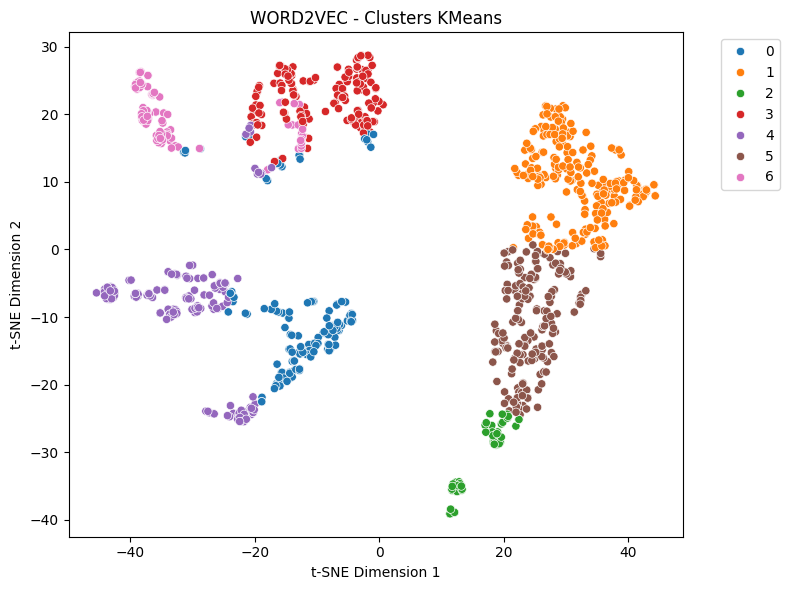

In [63]:
plot_tsne(X_2D, cluster_labels, "WORD2VEC - Clusters KMeans")

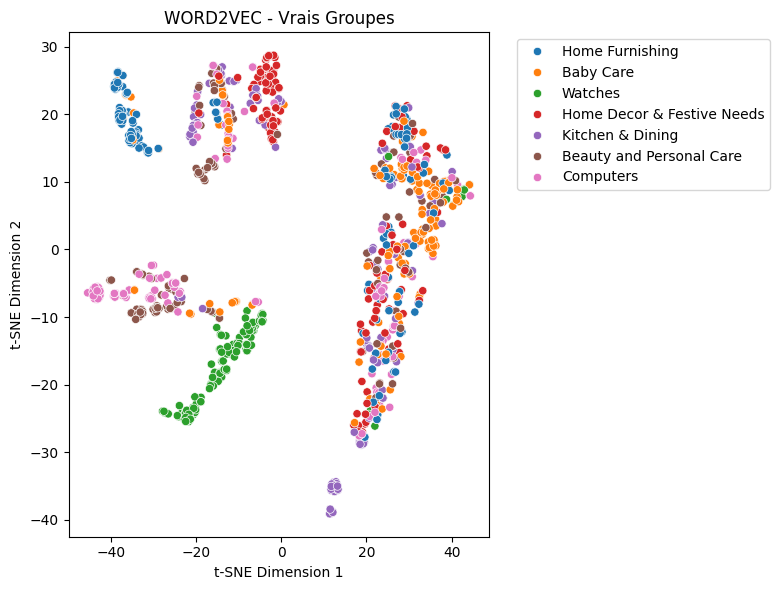

In [64]:
plot_tsne(X_2D, df["extracted_category"], "WORD2VEC - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>Word2Vec pour la colonne titre</u></h2>

In [65]:
afficher_tokens_titre = df["product_name"].dropna().apply(word_tokenize).tolist()

In [66]:
model = Word2Vec(
    sentences=afficher_tokens_titre,  # le corpus
    vector_size=100,             # dimension des vecteurs
    window=5,                    # taille du contexte
    min_count=2,                 # ignore les mots rares
    workers=4,                   # CPU cores
    sg=0                         # CBOW (mettre 1 pour skip-gram)
)

In [67]:
# Application sur le DataFrame
df["w2v_vector"] = df["tokens_titre"].apply(lambda x: vectorize_text(x, model))
X_titres = np.stack(df["w2v_vector"].values)

# Étape 2 : Réduction de dimension par t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_2D_titre = tsne.fit_transform(X_titres)

# Étape 3 : KMeans clustering
start5 = time.time()
kmeans = KMeans(n_clusters=7, random_state=0)
cluster_labels = kmeans.fit_predict(X_titres)
elapsed5 = time.time() - start5

# Étape 4 : ARI avec les vrais labels
ari = adjusted_rand_score(df["extracted_category"], cluster_labels)

now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative = "kmeans_word2Vec_titre"

logs.append({
    "nom_tentative": nom_tentative,
    "date_heure": now,
    "ARI": ari,
    "temps_sec": elapsed5
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)
    
print(f"Adjusted Rand Index (ARI) : {ari:.4f}")

Adjusted Rand Index (ARI) : 0.1300


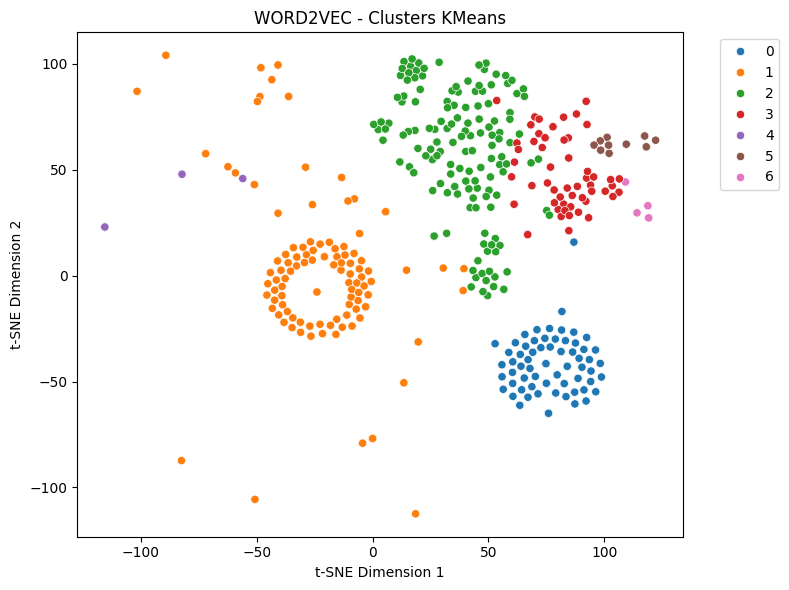

In [68]:
plot_tsne(X_2D_titre, cluster_labels, "WORD2VEC - Clusters KMeans")

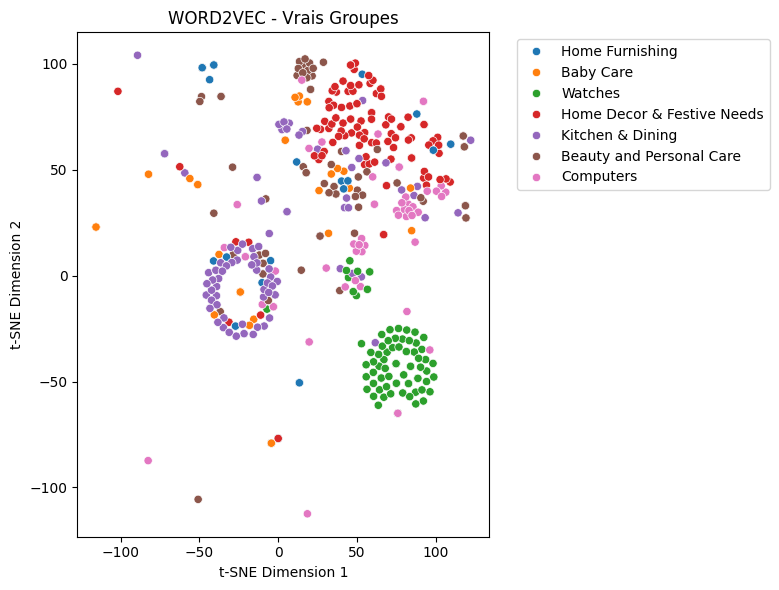

In [69]:
plot_tsne(X_2D_titre, df["extracted_category"], "WORD2VEC - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>BERT et USE</u></h2>

In [70]:
# Avec BERT
df["bert_vector"] = df["description"].apply(bert_vectorize)
X_bert = np.stack(df["bert_vector"].values)

# Avec USE
df["use_vector"] = df["description"].apply(use_vectorize)
X_use = np.stack(df["use_vector"].values)


In [71]:
X_2D_bert = reduce_tsne_bert_use(X_bert)
X_2D_use = reduce_tsne_bert_use(X_use)

In [72]:
start6 = time.time()
kmeans_bert = KMeans(n_clusters=7, random_state=42).fit(X_bert)
cluster_labels_bert = kmeans_bert.labels_
elapsed6 = time.time() - start6

start7 = time.time()
kmeans_use = KMeans(n_clusters=7, random_state=42).fit(X_use)
cluster_labels_use = kmeans_use.labels_
elapsed7 = time.time() - start7

In [73]:
ari_bert = adjusted_rand_score(df["extracted_category"], cluster_labels_bert)
print(f"ARI BERT : {ari_bert:.4f}")

now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative = "kmeans_bert"

logs.append({
    "nom_tentative": nom_tentative,
    "date_heure": now,
    "ARI": ari_bert,
    "temps_sec": elapsed6
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)

ari_use = adjusted_rand_score(df["extracted_category"], cluster_labels_use)
print(f"ARI USE : {ari_use:.4f}")

now = datetime.now().strftime("%Y-%m-%d %H:%M")
nom_tentative2 = "kmeans_use"

logs.append({
    "nom_tentative": nom_tentative2,
    "date_heure": now,
    "ARI": ari_use,
    "temps_sec": elapsed7
})

# (Optionnel) Sauvegarde CSV
with open("resultats_kmeans.csv", mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=logs[0].keys())
    if f.tell() == 0:  # Écrire l'entête si vide
        writer.writeheader()
    writer.writerows(logs)

ARI BERT : 0.2829
ARI USE : 0.3373


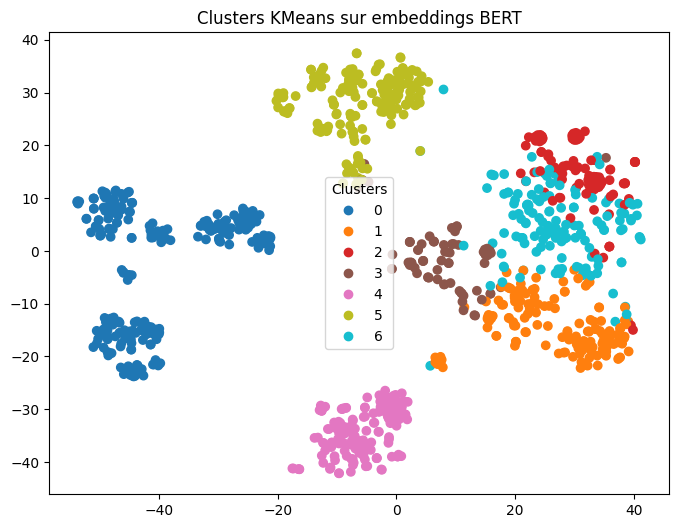

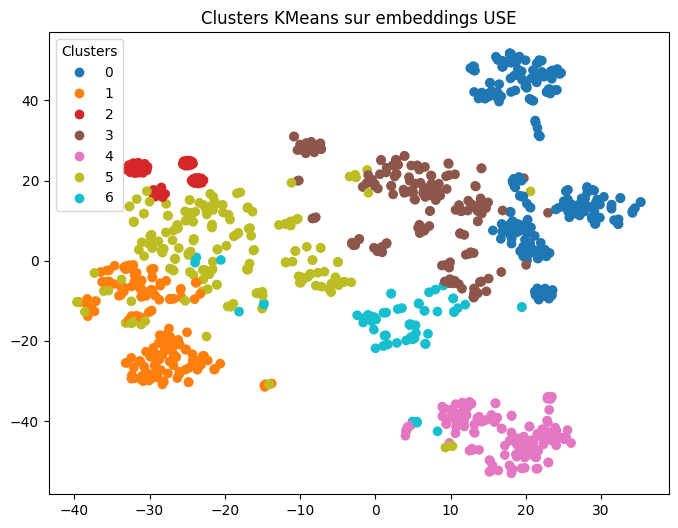

In [74]:
plot_2D_clusters(X_2D_bert, cluster_labels_bert, "Clusters KMeans sur embeddings BERT")
plot_2D_clusters(X_2D_use, cluster_labels_use, "Clusters KMeans sur embeddings USE")

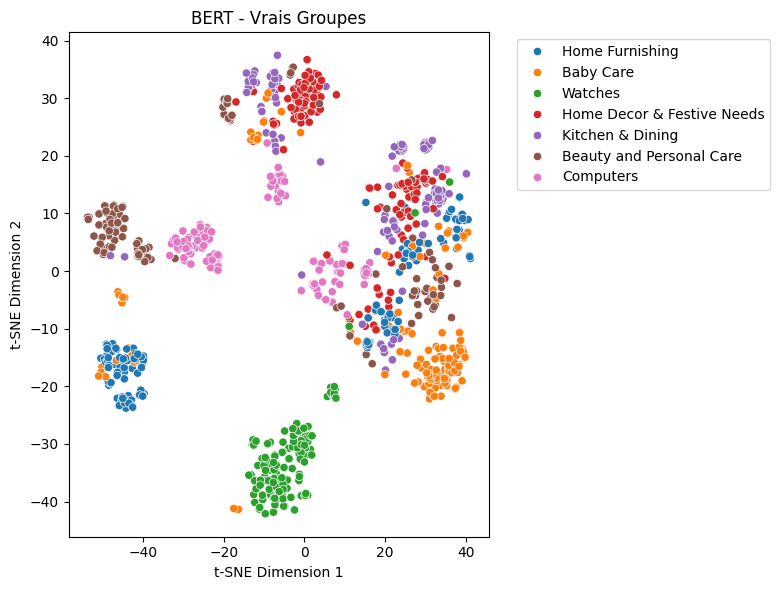

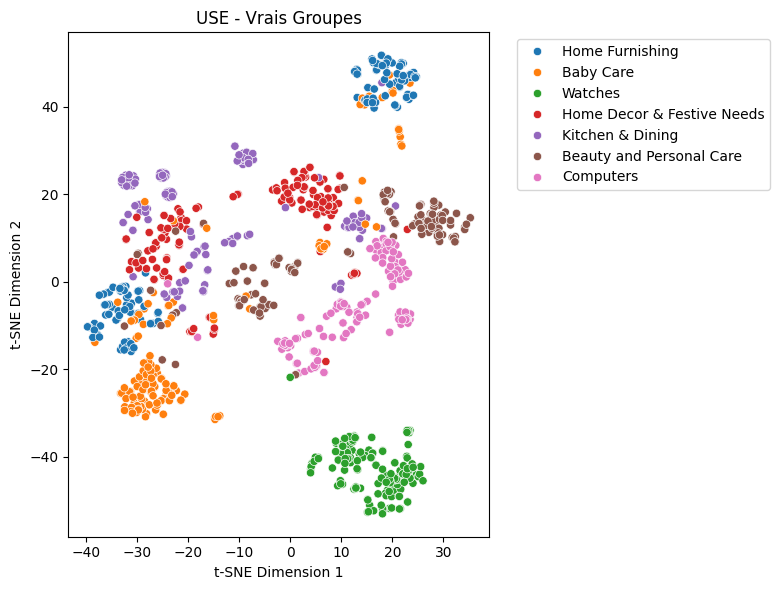

In [75]:
plot_tsne(X_2D_bert, df["extracted_category"], "BERT - Vrais Groupes")
plot_tsne(X_2D_use, df["extracted_category"], "USE - Vrais Groupes")

<h2 style="text-align: left; font-weight: bold;"><u>Tableau récapitulatif</u></h2>

In [76]:
resultats_kmeans = pd.read_csv("resultats_kmeans.csv")
resultats_kmeans.head()

nom_tentative        date_heure       ARI  temps_sec
0  kmeans_bag_of_words_description  2025-06-07 23:37  0.358975   0.022501
1  kmeans_bag_of_words_description  2025-06-07 23:37  0.358975   0.022501
2        kmeans_bag_of_words_titre  2025-06-07 23:37  0.392973   0.025437
3  kmeans_bag_of_words_description  2025-06-07 23:37  0.358975   0.022501
4        kmeans_bag_of_words_titre  2025-06-07 23:37  0.392973   0.025437

In [77]:
df_logs_sorted = resultats_kmeans.sort_values(by="ARI", ascending=False)
df_logs_unique = df_logs_sorted.drop_duplicates(subset="nom_tentative", keep="first")
df_logs_unique.head()

nom_tentative        date_heure       ARI  temps_sec
23         kmeans_TF_IDF_description  2025-06-07 23:38  0.520959   0.023563
100        kmeans_bag_of_words_titre  2025-06-08 18:57  0.392973   0.041111
66   kmeans_bag_of_words_description  2025-06-08 13:53  0.358975   0.037385
83                        kmeans_use  2025-06-08 16:09  0.337314   0.079589
76                       kmeans_bert  2025-06-08 16:09  0.282927   0.110408

<h1 style="text-align: center; font-weight: bold;"><u>1.1 Analyse images des produits</u></h1>

<h2 style="text-align: center; font-weight: bold;"><u>1.1.1 Prétraitement des données texte</u></h2>

<h2 style="text-align: center; font-weight: bold;"><u>1.1.2 Extraction de features texte</u></h2>

<h2 style="text-align: center; font-weight: bold;"><u>1.1.3 Réduction en 2 dimensions texte</u></h2>

<h1 style="text-align: center; font-weight: bold;"><u>1.1 Analyse image de produit</u></h1>